# Project

In [22]:
import tdmclient.notebook
await tdmclient.notebook.stop()

In [23]:
import numpy as np
import math
import time
from computer_vision import *
from dijkstra import compute_shortest_path
import tdmclient.notebook
await tdmclient.notebook.start()
#from tdmclient import ClientAsync, aw

In [24]:
# parametres
speed_r = 125
time_rotation = 7*speed_r/125

speed_f = 125
stop = 0

MIN_DIST = 20
ANGLE_TOLERANCE = 0.25

def motors_async(left, right):
    return {
        "motor.left.target": [left],
        "motor.right.target": [right],
    }


@tdmclient.notebook.sync_var
def motors(l_speed=500, r_speed=500):
    """
    Sets the motor speeds of the Thymio 
    param l_speed: left motor speed
    param r_speed: right motor speed
    """
    global motor_left_target, motor_right_target
    
    motor_left_target = l_speed
    motor_right_target = r_speed

#input : angle to change the trajectory
@tdmclient.notebook.sync_var
def orientation (angle):  
 #   global motor_left_target, motor_right_target
    if(angle >= 0 ):
        motors(-speed_r, speed_r)
    else:
        motors(speed_r, -speed_r)
    #if angle < 0:
    #    motors(speed_r, stop)
    #else :
    #    motors(stop, speed_r)
    #    
    time.sleep(0.01)
    

def get_angle_between(vec1, vec2):
    vec1_unit = vec1 / np.linalg.norm(vec1)
    vec2_unit = vec2 / np.linalg.norm(vec2)

    return np.arccos(np.dot(vec1_unit, vec2_unit))

#input : coordinates of two different points 
#return the distance between two points 
def distance (x1, y1, x2, y2):
    dist = np.sqrt((x1-x2)**2 + (y1-y2)**2)
    return dist

def wrap_angle(angle):
    if angle > math.pi:
        angle = angle - 2*math.pi
    elif angle < -math.pi:
        angle = angle + 2*math.pi
    return angle

In [25]:
def controller(goal_dist, angle):
    kp_rot = 40
    kp_lin = 3

    if abs(angle) > ANGLE_TOLERANCE:
        speed_l = 10 - kp_rot*(angle)
        speed_r = 10 + kp_rot*(angle)

    else:
        speed_l = 50
        speed_r = 50

    motors(int(speed_l),int(speed_r))
    
    


In [26]:
def mouving (video_capture, path, x0, y0, theta0, periode=0.01):
    teta = np.zeros(np.shape(path)[0])
   
    goalx = path[0][0]
    goaly = path[0][1]
    
    i = 0
    x_pense = x0
    y_pense = y0
    teta_pense = theta0
    
    kx = 0
    ky = 0
    kteta = 0
    angle = 0
   
    print('x =', x_pense, 'y =', y_pense, 'teta =', teta_pense)
    dist = distance (goalx, goaly, kx, ky)
    while i < np.shape(path)[0]:
        #[kx, ky, kteta] = kalman()
        
        ret, frame = video_capture.read()
        position_measure = []
        if ret == True:
            position_measure, position_contour,_ = computer_vision(frame, 'robot', False)
            position_measure = position_measure[0]
            if position_measure is not None:
                _, theta_measure = get_robot_position(frame, position_measure, position_contour)
            position_measure = invert_coordinates(position_measure)
            [kx, ky, kteta] = [position_measure[0], position_measure[1], -theta_measure]
            dist = distance (goalx, goaly, kx, ky)
        
        teta[i] = math.atan2((goaly - ky), (goalx - kx)) #change angle according to kalman

        
        if (dist < MIN_DIST):
            print('i = ',i)
            i = i + 1
            goalx = path[i][0]
            goaly = path[i][1]
            #motors(speed_f, speed_f)            
            x_pense = path[i-1][0]
            y_pense = path[i-1][1]
            vec1 = [np.cos(teta[i-1]), np.sin(teta[i-1])]
            vec2 = [goalx - x_pense, goaly - y_pense]
            angle = get_angle_between(vec1, vec2)
            
            teta_pense = angle + teta[i-1]
      
        else :
            x_pense = kx + speed_f * periode * np.cos(teta[i]) #à update
            y_pense = ky + speed_f * periode * np.sin(teta[i])
            teta_pense = teta[i]
            #kteta = teta[i]
            angle =  wrap_angle((teta[i] - kteta) % (2*np.pi))
            
            #time.sleep(periode)

        controller(dist,angle)
        print(i, ret, dist, position_measure, angle, teta[i], kteta)
        
        
   
    motors(stop, stop)

# Main 

1
2
3
start = [115.2 532. ] goal = [896. 416.]
path = [[256.  496.8]
 [608.8 599.2]
 [896.  416. ]]
789.3697739336109


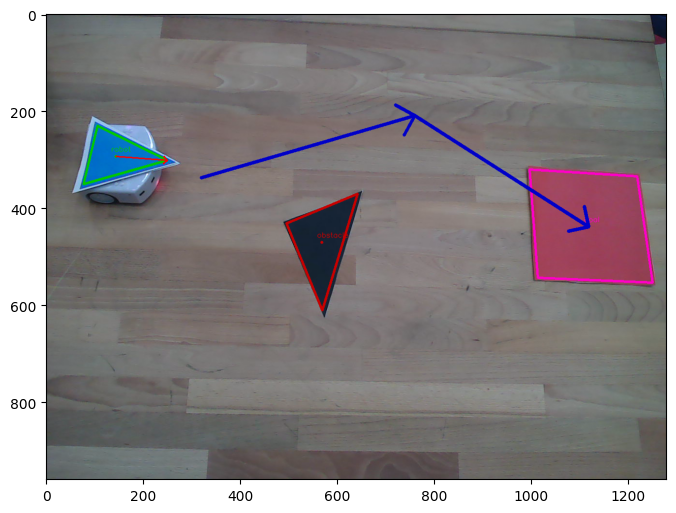

In [27]:
video_capture = cv2.VideoCapture(0,cv2.CAP_DSHOW)
fig, ax = plt.subplots(figsize=(8,8))
cv_successful, obst, robot, goal, frame = cv_start(video_capture, show_image= True, exposure=-8)
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
obst = format_contour(obst)


if cv_successful:
    start = np.array([robot[0], robot[1]])
    goal = np.array([goal[0], goal[1]])
    path = compute_shortest_path(obst, start, goal)
    path = np.rint(path).astype(int)
    frame = draw_path(frame, path) 
    
    metric_path = np.zeros(np.shape(path))

    # invert y axis
    for i in range(len(path)):
        path[i] = invert_coordinates(path[i])
    metric_start = invert_coordinates(start)
    metric_goal = invert_coordinates(goal)
    # change to metric  

    for i in range(len(path)):
        metric_path[i] = pixel_to_metric(path[i])
    metric_start = pixel_to_metric(metric_start)
    metric_goal = pixel_to_metric(metric_goal)
    
    

    print('start =', metric_start, 'goal =', metric_goal)
    print('path =', metric_path)

    print(distance(metric_start[0], metric_start[1], metric_goal[0], metric_goal[1]))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [28]:
#ret, frame = video_capture.read()
#print(ret)
#plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
#cv2.imwrite('frame.jpeg', frame)

motors(stop, stop)
np.shape(path)

(3, 2)

In [29]:
mouving(video_capture, path, robot[0], robot[1], robot[2], periode=0.01)
print("finished")
motors(stop, stop)

x = 144 y = 295 teta = 0.07532889082834011
0 True 181.41664752717708 [144, 665] -0.1696497722985244 -0.24497866312686414 -0.07532889082834011
0 True 181.1767093199344 [144, 664] -0.15570933502369133 -0.23962396196288266 -0.08391462693919144
0 True 181.41664752717708 [144, 665] -0.1696497722985244 -0.24497866312686414 -0.07532889082834011
0 True 180.20543831971332 [145, 664] -0.16561210917973668 -0.24094100000807706 -0.07532889082834011
0 True 176.32356620712955 [149, 664] -0.18041218829651484 -0.246354178077785 -0.06594198978127024
0 True 171.4788616710526 [154, 664] -0.16876251146897836 -0.25346502233863655 -0.08470251086965776
0 True 166.6433316997713 [159, 664] -0.18566004902498978 -0.26098893985333 -0.07532889082834011
0 True 161.8177987738061 [164, 664] -0.19433456390934367 -0.26896206961685626 -0.07462750570751274
0 True 156.0416611036937 [170, 664] -0.20385104963953626 -0.27917994046787675 -0.07532889082834011
0 True 150.9602596712128 [175, 663] -0.19802468842368715 -0.281939315

IndexError: index 3 is out of bounds for axis 0 with size 3